# PCA based portfolios

## Examples from currencies

### Get the data in
Let's start by getting the data on the FX trackers in the notebook:

In [1]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
fx_trackers = pd.read_csv('fx_trackers.csv',index_col=0)
fx_trackers.index = pd.to_datetime(fx_trackers.index)
fx_trackers.head()

,NOK,GBP,AUD,TWD,NZD,HUF,BRL,ZAR,PHP,IDR,...,INR,CNH,SEK,JPY,CZK,SGD,KRW,EUR,TRY,MXN
2004-04-23,105.77,124.25,111.59,96.44,119.55,157.02,113.82,130.02,132.55,315.00,...,133.99,NaN,97.87,61.96,132.37,96.48,110.45,136.56,290.29,124.14
2004-04-26,105.81,125.64,111.88,96.51,120.19,157.97,114.15,130.93,132.72,315.68,...,134.04,NaN,98.34,62.32,131.97,96.48,110.83,136.91,287.25,124.69
2004-04-27,106.73,125.90,111.82,96.62,120.14,157.94,113.92,131.09,132.91,315.82,...,133.90,NaN,98.81,61.69,132.15,96.45,111.04,137.48,283.48,124.45
2004-04-28,106.70,124.85,110.58,96.52,119.03,155.95,113.28,128.10,132.70,315.17,...,133.81,NaN,98.24,61.63,130.63,96.51,110.76,136.79,280.49,124.24
2004-04-29,107.74,125.03,110.05,96.08,118.77,157.68,112.70,127.92,132.43,314.68,...,133.13,NaN,98.88,61.50,132.76,96.18,109.67,137.94,281.46,123.56


Most techniques in statistics require the data to be stationary. Hopefully, you know what that means. There is a discussion among economics if spot FX time series are stationary or not. We are going to assume here they are not stationary and therefore look at things from a return point of view. Here we are going to look at rolling 21-bday returns data but the same concepts apply to other frequencies and to non-overlapping returns.

In [2]:
returns = np.log(fx_trackers.fillna(method='ffill')).diff(21).dropna(how='all')

From time to time, we will want to look at the data normalized to have mean zero and variance equal to one. That is, we will want to look at the z-scores:

In [3]:
zscores = ((returns-returns.mean())/returns.std()).dropna()

### Principal Components Analysis

PCA is a statistical method that explains variance-covariance structure by employing a linear combination of the original $p$ random variables $X_{1}, . . . ,X_{p}$. Let the $px1$ random vector $X = (X_{1}, . . . ,X_{p})'$ have the $pxp$ covariance matrix $\Omega$ with eigenvalues $\lambda_{1}\geq . . . \geq \lambda_{i} . . . \geq \lambda_{p}$ and associated eigenvectors $e_{1}, . . . ,e_{p}$.

The $i$-th principal component is the vector $P_{i} = e_{i}'X$.

By construction:

* $e_{i}'e_{i} = 1$ for all $i = 1,...,p$;
* $e_{i}'e_{j} = 0$ for all $i \neq j$;;
* $Var(P_{i}) = e_{i}'\Omega e_{i}$ for all $i = 1,...,p$;
* $Cov(P_{i},P_{j}) = e_{i}'\Omega e_{j}$ for all $i \neq j$;
* $\sum_{i=1}^{p} Var(X_{i}) = \sum_{i=1}^{p} \lambda_{i}$

**Note**: Note that if $P_{i}$ is principal component, then $-P_{i}$ could also be a principal component. That is, principal components are identified up to a sign. Different packages or even the same packages can spit out $P_{i}$ or $-P_{i}$ as their output. You never know. So, don't get bogged down on the direction of $P_{i}$.

It's simple to use sklearn.decomposition.PCA to compute the PCs of the data. Let's calculate the 5 principal components:

In [4]:
n_comp = 5
pca = PCA(n_components=n_comp)
PCAFactors = pd.DataFrame(index=zscores.dropna().index,
                 columns=['PC' + str(x) for x in range(1,n_comp+1)],
                 data=pca.fit_transform(zscores.dropna().values))

Let's take a look at the estimated eigenvectors $e_{1}, . . . ,e_{p}$. These eigenvectors can be understood as a type of senstivity to an underlying and unidentified "shock". If these variables are driven mostly by these 5 principal components than currency $k$ sensitivity to a shock on component $i$ is given by the $k-th$ component of $P_{i}$, $p_{i,k}$. We can think of $p_{i,k}$ as the "beta" of currency $k$ to shocks of type $i$.

Let's take a look how currencies look in terms of sensitivity to these principal components:

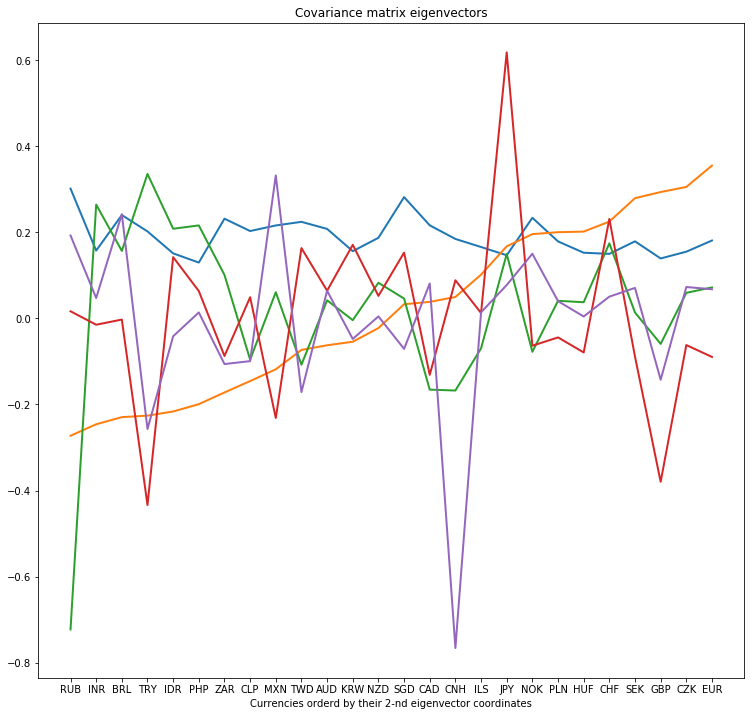

In [5]:
PCALoadings = pd.DataFrame(data=pca.components_,columns=zscores.columns,index=PCAFactors.columns).transpose()
PCALoadings = PCALoadings.sort_values(by='PC2')
plt.figure(0, figsize=(14, 13))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(PCALoadings.index,PCALoadings.values, linewidth=2)
plt.xlabel('Currencies orderd by their 2-nd eigenvector coordinates')
plt.title('Covariance matrix eigenvectors')
plt.show()

We are tempted to give an "interpretation" of carry to the 2nd PCA here but be careful.So, let's multiply the loadings to have the PCA pointed in the direction we want:

In [6]:
carry_direction = np.sign(PCALoadings.loc['RUB','PC2'] - PCALoadings.loc['EUR','PC2'])
PCALoadings = carry_direction*PCALoadings

### Portfolio weights and PC exposures

Now suppose we have a vector of weights $W = (W_{1}, . . . ,W_{p})'$, then the portfolio formed with those weights will be given by $X'W$ and the variance of this portfolio will be given by $W'\Omega W$. By the Single Value Decomposition of the real and symmetric $\Omega$ we have that $W'\Omega W = W' E \Lambda E' W$ where the columns of of the $pxp$ matrix $E$  are the eigenvectors $e_{1}, . . . ,e_{p}$ and $\Lambda$ is a diagonal matrix composed of the eigenvalues $\lambda_{1}\geq . . . \geq \lambda_{i} . . . \geq \lambda_{p}$.

We can think of $W'E$ as $\beta = W'E$ where $ \beta = (\beta_{1}, . . . ,\beta_{p})$ represents the projection of the weights $W$ on the orthogonal PC basis. Because $\Lambda$ is a diagonal matrix, the variance of the portfolio is given by $\sum_{i=1}^{p} \beta^{2}_{i} \lambda_{i}$ and risk attributed to the $i$-th PC is given by $\beta^{2}_{i} \lambda_{i}$. Often, we will express the contribution of the $i$-th PC to risk in percentage terms as in $\beta^{2}_{i} \lambda_{i} / (\beta'\Lambda \beta)$.

Let's see how a rank based portfolio, sorted on the loadings to PC2 distribute risk across PCs:

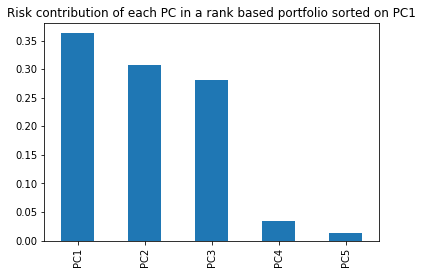

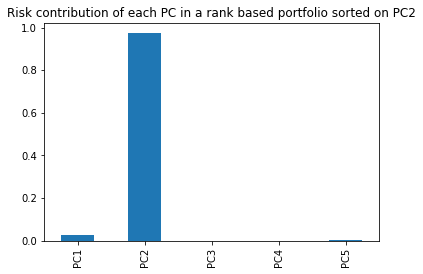

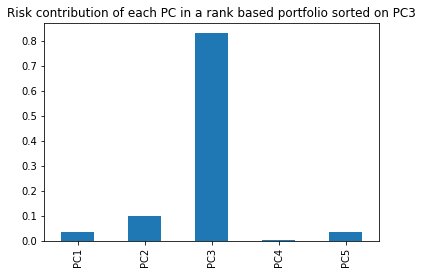

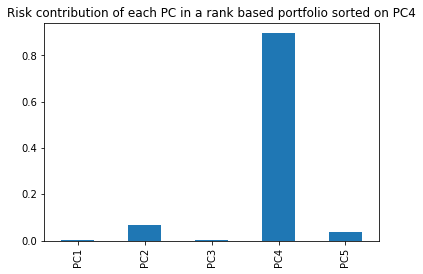

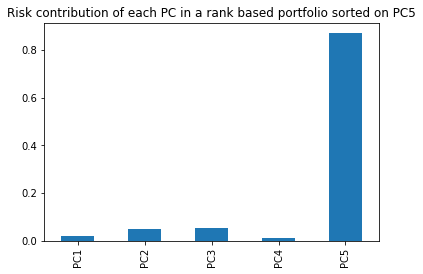

In [31]:
for pc in PCALoadings.columns:
    weights = PCALoadings[pc].rank()-PCALoadings[pc].rank().mean()
    betas = weights.T@PCALoadings
    lambdas = pd.Series(index=betas.index,data=pca.explained_variance_)
    risk_contribution = (betas**2)*lambdas
    risk_contribution = risk_contribution/risk_contribution.sum()
    risk_contribution.plot(kind='bar')
    plt.title('Risk contribution of each PC in a rank based portfolio sorted on %s' % pc)
    plt.show()

### Choosing weights to get PC exposure

If PC1 is considered the "market" and PC2 has a high "carry" component to it, we may be intereted in designing a portfolio that gives as equal exposure to PC3, PC4, and PC5 but not exposure to PC1 and PC2. That is, we want $\beta^{2}_{i} \lambda_{i} / (\beta'\Lambda \beta) = 0$ for $i=1,2$ and $\beta^{2}_{i} \lambda_{i} / (\beta'\Lambda \beta) = 1/3$ for $i=3,4,5$. Hence, the vector $\beta = (0,0,\sigma/\sqrt{3\lambda_{3}},\sigma/\sqrt{3\lambda_{4}},\sigma/\sqrt{3\lambda_{5}})$ where $\sigma$ is some volatility target for the portfolio:

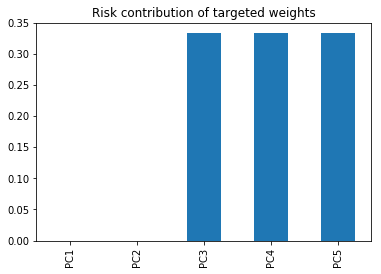

In [44]:
targeted_vol = 0.1 
target_beta = targeted_vol*(np.sqrt(3*lambdas)**-1)
target_beta.iloc[[0,1]] = 0
target_weights = PCALoadings@target_beta
risk_contribution = (target_beta**2)*lambdas 
risk_contribution = risk_contribution/risk_contribution.sum()
risk_contribution.plot(kind='bar')
plt.title('Risk contribution of targeted weights')
plt.show()